<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula3c_multiclasse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def criaDatasetMulticlasse(n=20, n_classes=3):
  X, y = make_blobs(n_samples=n, centers=n_classes, center_box=(0,1.0), cluster_std=0.02)
  return X, y

n_classes = 4
X, y = criaDatasetMulticlasse(1000, n_classes)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)
X.shape, y.shape

((1000, 2), (1000,))

In [48]:
set(ytr)

{0, 1, 2, 3}

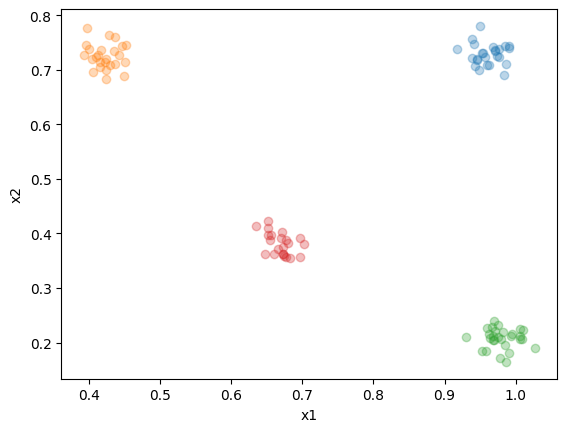

In [33]:
import matplotlib.pyplot as plt

def plotDataset(X, y):
  plt.xlabel('x1')
  plt.ylabel('x2')
  for k in set(y):
    plt.plot(X[:,0][y==k],X[:,1][y==k], 'o', alpha=0.3)

plotDataset(Xtr, ytr)

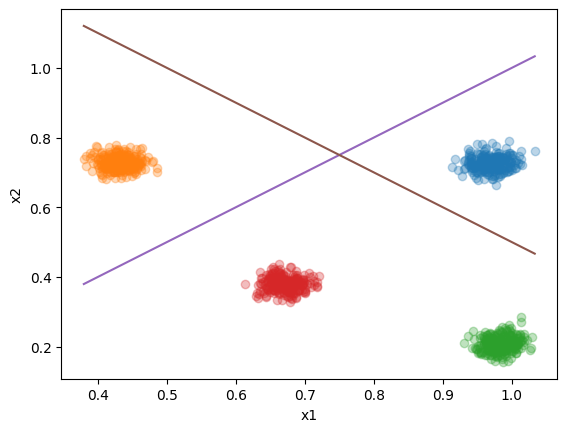

In [44]:
def plotHiperplano(X, y, vetor, intercept=0):
  x0min = min(X[:,0])
  x0max = max(X[:,0])
  xs = np.linspace(x0min, x0max, num=2)
  ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
  plt.plot(xs, ys)

plotDataset(X, y)
vetor_hiperplano = np.array([1,1]) * np.array([1, -1])
plotHiperplano(X, y, vetor_hiperplano, 0)
vetor_hiperplano = np.array([1,-1]) * np.array([1, -1])
plotHiperplano(X, y, vetor_hiperplano, -1.5)

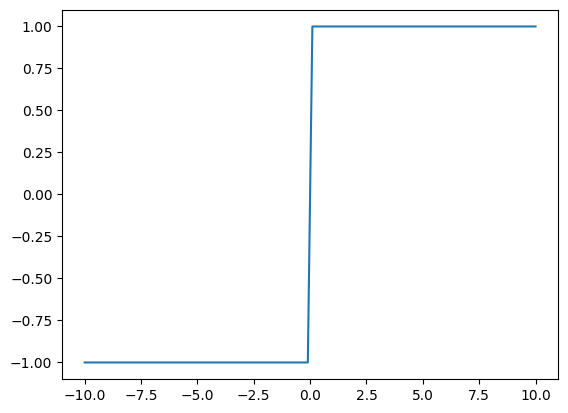

In [45]:
def sign(a):
  return (a >= 0) * 2 -1

a = np.linspace(-10,10,100)
out = sign(a)
plt.plot(a, out)
plt.show()

In [46]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
  @abstractstaticmethod
  def custo(y, ypred):
    pass
  @abstractstaticmethod
  def gradiente(y, ypred, X):
    pass

class WidrowHoff(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum((y-ypred)**2)
  @staticmethod
  def gradiente(y, ypred, X):
    return X.T @ (y - ypred)

class SmoothSurrogate(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), -y * ypred))
  @staticmethod
  def gradiente(y, ypred, X):
    return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
  @staticmethod
  def custo(y, ypred):
    return  np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
  @staticmethod
  def gradiente(y, ypred, X):
    errosmarginais = (y * ypred) < 1
    ymarginais = np.copy(y)
    ymarginais[~errosmarginais] = 0
    return X.T @ ymarginais

from scipy.special import expit

class LogLikehood(Custo):
  @staticmethod
  def custo(y, ypred):
    return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
  @staticmethod
  def gradiente(y, ypred, X):
    return X.T @ (y - (expit(ypred)*2-1))

In [49]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y, activation=None):
    pass

class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=500, learning_rate=0.01,
               regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      ypred = X @ w
      erros = y - ypred
      if self.cost.custo(y, ypred) == 0:
        break
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.gradiente(y, ypred, X) * self.learning_rate
    return w


In [53]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

def include_bias(X):
  bias = np.ones((X.shape[0],1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=DescidaGradiente()):
    self.w = None
    self.activation = sign
    self.training_algorithm = training_algorithm

  def encode_labels(self, y):
    self.labels = sorted(list(set(y)))
    return label_binarize(y, classes=self.labels)*2-1

  def fit(self, X, y):
    Xb = include_bias(X)
    yhot = self.encode_labels(y)
    self.w = self.training_algorithm.getW(Xb, yhot)

  def __pre_activation(self, X):
    Xb = include_bias(X)
    return Xb @ self.w

  def predict(self, X):
    a = self.__pre_activation(X)
    if self.w.shape[1] == 1:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred


1.0
[[-28.40794915   2.74361574  -8.05724176  48.93043801]
 [ 18.96389502 -22.28464198  18.44930931 -43.23108295]
 [ 20.46714402  16.84491765 -24.39640483 -46.30665486]]
1.0


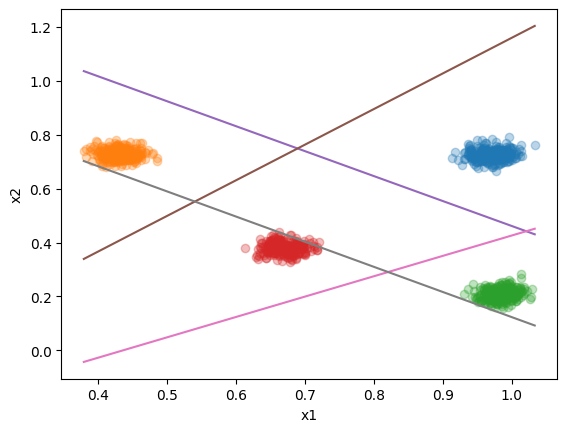

In [59]:
from sklearn.metrics import accuracy_score

costs = [
    # WidrowHoff(),
    # SmoothSurrogate(),
    # HingeLoss(),
    LogLikehood(),
    ]
for cost in costs:
  # for _ in range(2):
    perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=cost))
    perceptron.fit(X, y)
    ypred = perceptron.predict(X)
    print(accuracy_score(y, ypred))
    print(perceptron.w)
    plotDataset(X, y)
    # plotDataset(X, ypred)
    for i in range(perceptron.w.shape[1]):
      plotHiperplano(X, y, perceptron.w[1:,i], perceptron.w[0,i])
    ypred = perceptron.predict(Xte)
    print(accuracy_score(yte, ypred))
    # print(perceptron.w)
    plt.show()
    # plotDataset(Xte, yte)
    # # plotDataset(X, ypred)
    # plotHiperplano(Xte, yte, perceptron.w[1:], perceptron.w[0])
    # plt.show()